In [13]:
import sys
sys.path.append('/Users/tim/Desktop/Speech/lab1')
sys.path.append('/Users/tim/Desktop/Speech/lab2')
import numpy as np
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


from lab3_tools import *
from lab3_proto import *

In [14]:
# phoneHMMs is a dictionary with 21 keys, each corresponding to a phonetic model
phoneHMMs = np.load('../lab2/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
# A list of unique states for reference
# Note that we model three segments for each phoneme
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList[39]

'sil_0'

# Forced Alignment

In [15]:
# Read the audio and compute liftered MFCC features
from lab1_proto import mfcc

filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

In [16]:
# Recover the sequence of digits (word level transcription) in the file
wordTrans = list(path2info(filename)[2])
wordTrans

['z', '4', '3']

In [17]:
from prondict import prondict
phoneTrans = words2phones(wordTrans, prondict)
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [18]:
from lab2_proto import concatHMMs

# Create a combined model for this specific utterance:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

In [19]:
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]

In [20]:
from lab2_tools import log_multivariate_normal_density_diag
from lab2_proto import viterbi

# NxM array of emission(observation) log likelihoods, N frames, M states
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars']) 
log_startprob = np.log(utteranceHMM['startprob'][:-1])
log_transmat = np.log(utteranceHMM['transmat'][:-1, :-1])
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)

stateList = [stateTrans[i] for i in vpath]
stateList

['sil_0',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_2',
 'z_0',
 'z_0',
 'z_0',
 'z_0',
 'z_1',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'f_0',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'th_0',


# Feature Extraction

In [21]:
# from lab1_proto import mspec

# traindata = []
# for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'):
#     for file in files:
#         if file.endswith('.wav'):
#             filename = os.path.join(root, file)
#             samples, samplingrate = loadAudio(filename)
#             lmfcc = mfcc(samples)
#             mspecs = mspec(samples)
#             targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
#             traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecs, 'targets': targets})
# np.savez('traindata.npz', traindata=traindata)

# testdata = []
# for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'):
#     for file in files:
#         if file.endswith('.wav'):
#             filename = os.path.join(root, file)
#             samples, samplingrate = loadAudio(filename)
#             lmfcc = mfcc(samples)
#             mspecs = mspec(samples)
#             targets = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)
#             testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecs, 'targets': targets})
# np.savez('testdata.npz', testdata=testdata)

# Training and Validation Sets

In [22]:
train_data = np.load('traindata.npz', allow_pickle=True)['traindata']
test_data = np.load('testdata.npz', allow_pickle=True)['testdata']

In [23]:
random.seed(420)

# Include original data with parsed information
data_list = []
for item in train_data:
    filename = item['filename']
    info_tuple = path2info(filename)
    data_list.append((info_tuple, item))  # Store tuple of parsed info and the full data item

from collections import defaultdict
# Separate data by gender
gender_data = defaultdict(list)
for info, full_data in data_list:
    gender_data[info[0]].append((info, full_data))


train_set = []
valid_set = []

# Split data for each gender
for gender, items in gender_data.items():
    # Group by speaker
    speaker_data = defaultdict(list)
    for info, full_data in items:
        speaker_data[info[1]].append(full_data)
    
    # Create lists of speakers and shuffle them
    speakers = list(speaker_data.keys())
    random.shuffle(speakers)
    
    # Calculate number of speakers for training
    num_train_speakers = int(round(len(speakers) * 0.9))
    
    # Split speakers into training and validation
    train_speakers = speakers[:num_train_speakers]
    valid_speakers = speakers[num_train_speakers:]
    
    # Aggregate the data entries for each set of speakers
    for spkr in train_speakers:
        train_set.extend(speaker_data[spkr])
    for spkr in valid_speakers:
        valid_set.extend(speaker_data[spkr])

# Shuffle the sets to ensure random order
random.shuffle(train_set)
random.shuffle(valid_set)

# Acoustic Context (Dynamic Features)

In [24]:
dlmfcc_train_x = []
dmspec_train_x = []
for i in range(len(train_set)):
    current_utterance = train_set[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_train_x.append(temp_mfcc_stack)
        dmspec_train_x.append(temp_mspec_features)

dlmfcc_train_x = np.array(dlmfcc_train_x)
dmspec_train_x = np.array(dmspec_train_x) 

#---------------------------------------------------------#
dlmfcc_val_x = []
dmspec_val_x = []
for i in range(len(valid_set)):
    current_utterance = valid_set[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_val_x.append(temp_mfcc_stack)
        dmspec_val_x.append(temp_mspec_features)

dlmfcc_val_x = np.array(dlmfcc_val_x)
dmspec_val_x = np.array(dmspec_val_x) 
    
#---------------------------------------------------------#
dlmfcc_test_x = []
dmspec_test_x = []
for i in range(len(test_data)):
    current_utterance = test_data[i]
    num_timesteps = current_utterance['lmfcc'].shape[0]

    for t in range(num_timesteps):
        temp_mfcc_stack = []
        temp_mspec_features = []
        for j in range(t - 3, t + 3 + 1):
            if j < 0:
                # Mirror at the beginning
                temp_mfcc_stack.extend(current_utterance['lmfcc'][abs(j)])
                temp_mspec_features.extend(current_utterance['mspec'][abs(j)])
            elif j >= num_timesteps:
                # Mirror at the end
                temp_mfcc_stack.extend(current_utterance['lmfcc'][2 * num_timesteps - j - 1])
                temp_mspec_features.extend(current_utterance['mspec'][2 * num_timesteps - j - 1])
            else:
                # Normal case
                temp_mfcc_stack.extend(current_utterance['lmfcc'][j])
                temp_mspec_features.extend(current_utterance['mspec'][j])
        
        # Flatten the data structures as specified at 4.6
        dlmfcc_test_x.append(temp_mfcc_stack)
        dmspec_test_x.append(temp_mspec_features)

dlmfcc_test_x = np.array(dlmfcc_test_x)
dmspec_test_x = np.array(dmspec_test_x) 

# Feature Standardisation

### What will happen with the very short utterances in the files containing isolated digits when normalizing each utterance individually?

Short utterances will have less reliable estimates of mean and variance, leading to potentially unstable feature scaling.

Extreme normalization values might occur if a particular feature deviates slightly in a short utterance, as there's less data to average out noise and variability. This can exaggerate the importance of minor variations in short utterances, potentially skewing the model training or performance.

In [25]:
lmfcc_train_x = []
mspec_train_x = []
train_y = []
for i in range(len(train_set)):
    lmfcc_train_x.append(train_set[i]['lmfcc'])
    mspec_train_x.append(train_set[i]['mspec'])
    train_y.append(train_set[i]['targets'])
lmfcc_train_x = np.concatenate(lmfcc_train_x, axis=0)
mspec_train_x = np.concatenate(mspec_train_x, axis=0)
train_y = np.concatenate(train_y, axis=0)
#---------------------------------------------------------#
lmfcc_val_x = []
mspec_val_x = []
val_y = []
for i in range (len(valid_set)):
    lmfcc_val_x.append(valid_set[i]['lmfcc'])
    mspec_val_x.append(valid_set[i]['mspec'])
    val_y.append(valid_set[i]['targets'])
lmfcc_val_x = np.concatenate(lmfcc_val_x, axis=0)
mspec_val_x = np.concatenate(mspec_val_x, axis=0)
val_y = np.concatenate(val_y, axis=0)
#---------------------------------------------------------#
lmfcc_test_x = []
mspec_test_x = []
test_y = []
for i in range (len(test_data)):
    lmfcc_test_x.append(test_data[i]['lmfcc'])
    mspec_test_x.append(test_data[i]['mspec'])
    test_y.append(test_data[i]['targets'])
lmfcc_test_x = np.concatenate(lmfcc_test_x, axis=0)
mspec_test_x = np.concatenate(mspec_test_x, axis=0)
test_y = np.concatenate(test_y, axis=0)

In [26]:
print(lmfcc_train_x.shape)
print(lmfcc_val_x.shape)
print(lmfcc_test_x.shape)
print()
print(mspec_train_x.shape)
print(mspec_val_x.shape)
print(mspec_test_x.shape)
print()
print(dlmfcc_train_x.shape)
print(dlmfcc_val_x.shape)
print(dlmfcc_test_x.shape)
print()
print(dmspec_train_x.shape)
print(dmspec_val_x.shape)
print(dmspec_test_x.shape)

(1363305, 13)
(144087, 13)
(1527014, 13)

(1363305, 40)
(144087, 40)
(1527014, 40)

(1363305, 91)
(144087, 91)
(1527014, 91)

(1363305, 280)
(144087, 280)
(1527014, 280)


In [27]:
from sklearn.preprocessing import StandardScaler

lmfcc_scaler = StandardScaler()
dlmfcc_scaler = StandardScaler()
mspec_scaler = StandardScaler()
dmspec_scaler = StandardScaler()

lmfcc_train_x = lmfcc_scaler.fit_transform(lmfcc_train_x)
dlmfcc_train_x = dlmfcc_scaler.fit_transform(dlmfcc_train_x)
mspec_train_x = mspec_scaler.fit_transform(mspec_train_x)
dmspec_train_x = dmspec_scaler.fit_transform(dmspec_train_x)
lmfcc_train_x = torch.tensor(lmfcc_train_x, dtype=torch.float32)
dlmfcc_train_x = torch.tensor(dlmfcc_train_x, dtype=torch.float32)
mspec_train_x = torch.tensor(mspec_train_x, dtype=torch.float32)
dmspec_train_x = torch.tensor(dmspec_train_x, dtype=torch.float32)

# Transform validation and test data using the normalization coefficients from training data
lmfcc_val_x = lmfcc_scaler.transform(lmfcc_val_x)
dlmfcc_val_x = dlmfcc_scaler.transform(dlmfcc_val_x)
mspec_val_x = mspec_scaler.transform(mspec_val_x)
dmspec_val_x = dmspec_scaler.transform(dmspec_val_x)
lmfcc_val_x = torch.tensor(lmfcc_val_x, dtype=torch.float32)
dlmfcc_val_x = torch.tensor(dlmfcc_val_x, dtype=torch.float32)
mspec_val_x = torch.tensor(mspec_val_x, dtype=torch.float32)
dmspec_val_x = torch.tensor(dmspec_val_x, dtype=torch.float32)

lmfcc_test_x = lmfcc_scaler.transform(lmfcc_test_x)
dlmfcc_test_x = dlmfcc_scaler.transform(dlmfcc_test_x)
mspec_test_x = mspec_scaler.transform(mspec_test_x)
dmspec_test_x = dmspec_scaler.transform(dmspec_test_x)
lmfcc_test_x = torch.tensor(lmfcc_test_x, dtype=torch.float32)
dlmfcc_test_x = torch.tensor(dlmfcc_test_x, dtype=torch.float32)
mspec_test_x = torch.tensor(mspec_test_x, dtype=torch.float32)
dmspec_test_x = torch.tensor(dmspec_test_x, dtype=torch.float32)

In [28]:
output_dim = len(stateList)
train_y = F.one_hot(torch.tensor(train_y), num_classes=output_dim).float()
val_y = F.one_hot(torch.tensor(val_y), num_classes=output_dim).float()
test_y = F.one_hot(torch.tensor(test_y), num_classes=output_dim).float()

In [29]:
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

torch.Size([1363305, 178])
torch.Size([144087, 178])
torch.Size([1527014, 178])


# Phoneme Recognition with Deep Neural Networks

In [30]:
# Define the DNN model class
class PhonemeDNN(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden_layers=0, num_units=256):
        super(PhonemeDNN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, num_units))
        self.layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(num_units, num_units))
            self.layers.append(nn.ReLU())
        
        # Output layer
        self.layers.append(nn.Linear(num_units, num_classes))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
def calculate_accuracy(outputs, labels):
    # Assuming outputs are logits and labels are one-hot encoded
    predicted = torch.argmax(outputs, dim=1)
    actual = torch.argmax(labels, dim=1)
    correct = (predicted == actual).float().sum()
    accuracy = correct / labels.shape[0]
    return accuracy

In [32]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256, epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()  # Recommended for one-hot encoded targets

    train_accuracies = []
    val_accuracies = []

    num_samples = X_train.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            
            inputs = X_train[start_idx:end_idx]
            labels = y_train[start_idx:end_idx]
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            total_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
        
        average_train_accuracy = total_accuracy / num_samples
        train_accuracies.append(average_train_accuracy)
        
        # Validation
        model.eval()
        total_val_accuracy = 0.0
        with torch.no_grad():
            num_val_samples = X_val.shape[0]
            outputs = model(X_val)
            total_val_accuracy = calculate_accuracy(outputs, y_val)
            val_accuracies.append(total_val_accuracy)

        print(f'Epoch {epoch+1}, Train Accuracy: {average_train_accuracy:.4f}, Validation Accuracy: {total_val_accuracy:.4f}')

    # Testing
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_accuracy = calculate_accuracy(outputs, y_test)
        print(f'Test Accuracy: {test_accuracy:.4f}')
    
    return train_accuracies, val_accuracies
    

In [33]:
# Hyperparameters
num_classes = len(stateList) 
batch_size=256
epochs=15
learning_rate=0.001

### 1. Input: Liftered MFCCs, 1 & 4 hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.3835, Validation Accuracy: 0.3995
Epoch 2, Train Accuracy: 0.4139, Validation Accuracy: 0.4091
Epoch 3, Train Accuracy: 0.4202, Validation Accuracy: 0.4140
Epoch 4, Train Accuracy: 0.4242, Validation Accuracy: 0.4161
Epoch 5, Train Accuracy: 0.4270, Validation Accuracy: 0.4179
Epoch 6, Train Accuracy: 0.4290, Validation Accuracy: 0.4188
Epoch 7, Train Accuracy: 0.4308, Validation Accuracy: 0.4197
Epoch 8, Train Accuracy: 0.4323, Validation Accuracy: 0.4200
Epoch 9, Train Accuracy: 0.4336, Validation Accuracy: 0.4199
Epoch 10, Train Accuracy: 0.4348, Validation Accuracy: 0.4202
Epoch 11, Train Accuracy: 0.4357, Validation Accuracy: 0.4201
Epoch 12, Train Accuracy: 0.4366, Validation Accuracy: 0.4202
Epoch 13, Train Accuracy: 0.4375, Validation Accuracy: 0.4206
Epoch 14, Train Accuracy: 0.4382, Validation Accuracy: 0.4203
Epoch 15, Train Accuracy: 0.4390, Validation Accuracy: 0.4206
Test Accuracy: 0.4202
Epoch 1, Train Accuracy: 0.3587, Validation Accuracy: 0.4

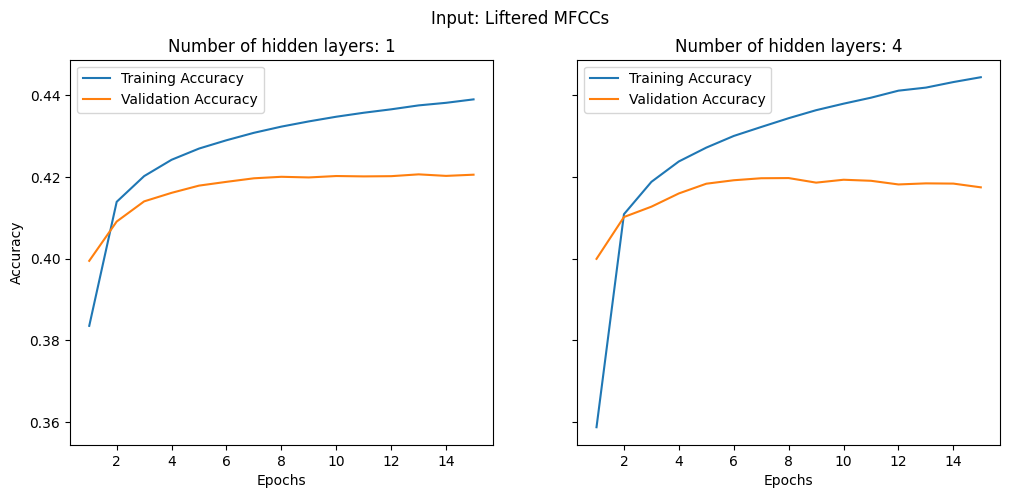

In [34]:
input_size = 13
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, lmfcc_train_x, train_y, lmfcc_val_x, val_y, lmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, lmfcc_train_x, train_y, lmfcc_val_x, val_y, lmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Liftered MFCCs')
plt.show()

### 2. Input: Filterbank features, one to four hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.3726, Validation Accuracy: 0.3940
Epoch 2, Train Accuracy: 0.4063, Validation Accuracy: 0.4043
Epoch 3, Train Accuracy: 0.4144, Validation Accuracy: 0.4107
Epoch 4, Train Accuracy: 0.4197, Validation Accuracy: 0.4146
Epoch 5, Train Accuracy: 0.4232, Validation Accuracy: 0.4169
Epoch 6, Train Accuracy: 0.4260, Validation Accuracy: 0.4189
Epoch 7, Train Accuracy: 0.4281, Validation Accuracy: 0.4190
Epoch 8, Train Accuracy: 0.4301, Validation Accuracy: 0.4198
Epoch 9, Train Accuracy: 0.4316, Validation Accuracy: 0.4199
Epoch 10, Train Accuracy: 0.4333, Validation Accuracy: 0.4196
Epoch 11, Train Accuracy: 0.4348, Validation Accuracy: 0.4194
Epoch 12, Train Accuracy: 0.4358, Validation Accuracy: 0.4191
Epoch 13, Train Accuracy: 0.4370, Validation Accuracy: 0.4204
Epoch 14, Train Accuracy: 0.4381, Validation Accuracy: 0.4211
Epoch 15, Train Accuracy: 0.4390, Validation Accuracy: 0.4219
Test Accuracy: 0.4186
Epoch 1, Train Accuracy: 0.3543, Validation Accuracy: 0.3

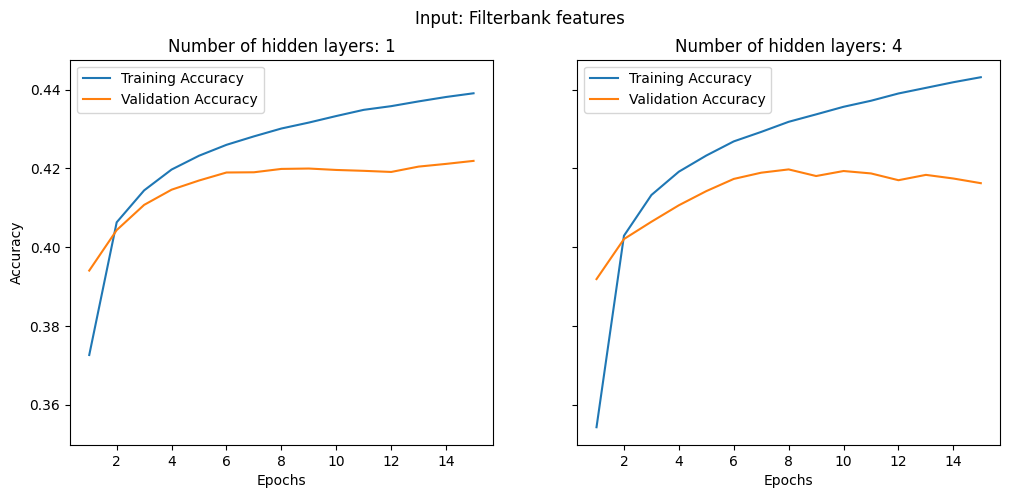

In [35]:
input_size = 40
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, mspec_train_x, train_y, mspec_val_x, val_y, mspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, mspec_train_x, train_y, mspec_val_x, val_y, mspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Filterbank features')
plt.show()

### 3. Input: Dynamic liftered MFCCs, 1 & 4 hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.4171, Validation Accuracy: 0.4453
Epoch 2, Train Accuracy: 0.4577, Validation Accuracy: 0.4591
Epoch 3, Train Accuracy: 0.4696, Validation Accuracy: 0.4668
Epoch 4, Train Accuracy: 0.4797, Validation Accuracy: 0.4724
Epoch 5, Train Accuracy: 0.4855, Validation Accuracy: 0.4755
Epoch 6, Train Accuracy: 0.4894, Validation Accuracy: 0.4775
Epoch 7, Train Accuracy: 0.4924, Validation Accuracy: 0.4788
Epoch 8, Train Accuracy: 0.4950, Validation Accuracy: 0.4784
Epoch 9, Train Accuracy: 0.4971, Validation Accuracy: 0.4792
Epoch 10, Train Accuracy: 0.4991, Validation Accuracy: 0.4791
Epoch 11, Train Accuracy: 0.5005, Validation Accuracy: 0.4811
Epoch 12, Train Accuracy: 0.5019, Validation Accuracy: 0.4800
Epoch 13, Train Accuracy: 0.5030, Validation Accuracy: 0.4792
Epoch 14, Train Accuracy: 0.5041, Validation Accuracy: 0.4800
Epoch 15, Train Accuracy: 0.5048, Validation Accuracy: 0.4799
Test Accuracy: 0.4807
Epoch 1, Train Accuracy: 0.3890, Validation Accuracy: 0.4

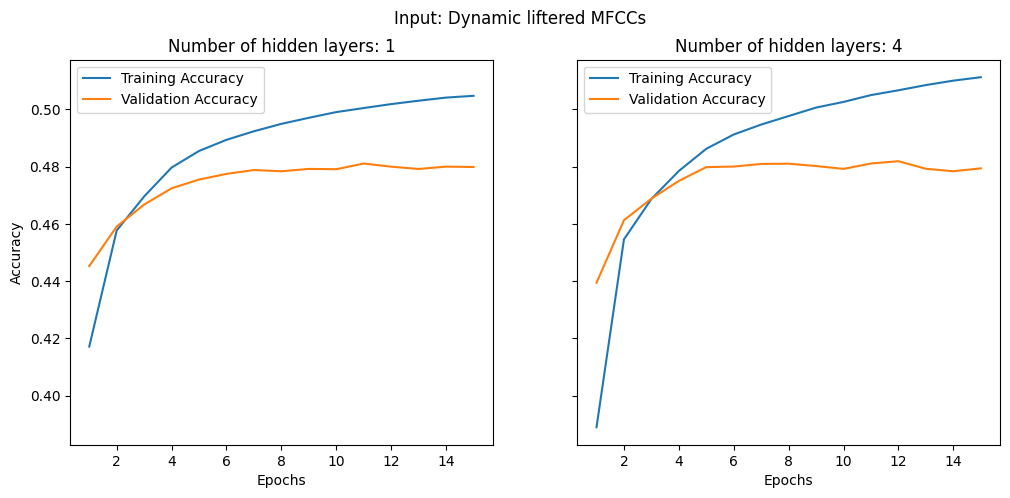

In [36]:
input_size = 91
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, dlmfcc_train_x, train_y, dlmfcc_val_x, val_y, dlmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, dlmfcc_train_x, train_y, dlmfcc_val_x, val_y, dlmfcc_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Dynamic liftered MFCCs')
plt.show()

### 4. Input: Dynamic filterbank features, one to four hidden layers of size 256, rectified linear units

Epoch 1, Train Accuracy: 0.4069, Validation Accuracy: 0.4237
Epoch 2, Train Accuracy: 0.4500, Validation Accuracy: 0.4469
Epoch 3, Train Accuracy: 0.4604, Validation Accuracy: 0.4587
Epoch 4, Train Accuracy: 0.4675, Validation Accuracy: 0.4637
Epoch 5, Train Accuracy: 0.4722, Validation Accuracy: 0.4647
Epoch 6, Train Accuracy: 0.4757, Validation Accuracy: 0.4691
Epoch 7, Train Accuracy: 0.4784, Validation Accuracy: 0.4671
Epoch 8, Train Accuracy: 0.4807, Validation Accuracy: 0.4657
Epoch 9, Train Accuracy: 0.4827, Validation Accuracy: 0.4659
Epoch 10, Train Accuracy: 0.4843, Validation Accuracy: 0.4656
Epoch 11, Train Accuracy: 0.4862, Validation Accuracy: 0.4674
Epoch 12, Train Accuracy: 0.4877, Validation Accuracy: 0.4660
Epoch 13, Train Accuracy: 0.4889, Validation Accuracy: 0.4660
Epoch 14, Train Accuracy: 0.4897, Validation Accuracy: 0.4677
Epoch 15, Train Accuracy: 0.4912, Validation Accuracy: 0.4683
Test Accuracy: 0.4685
Epoch 1, Train Accuracy: 0.3867, Validation Accuracy: 0.4

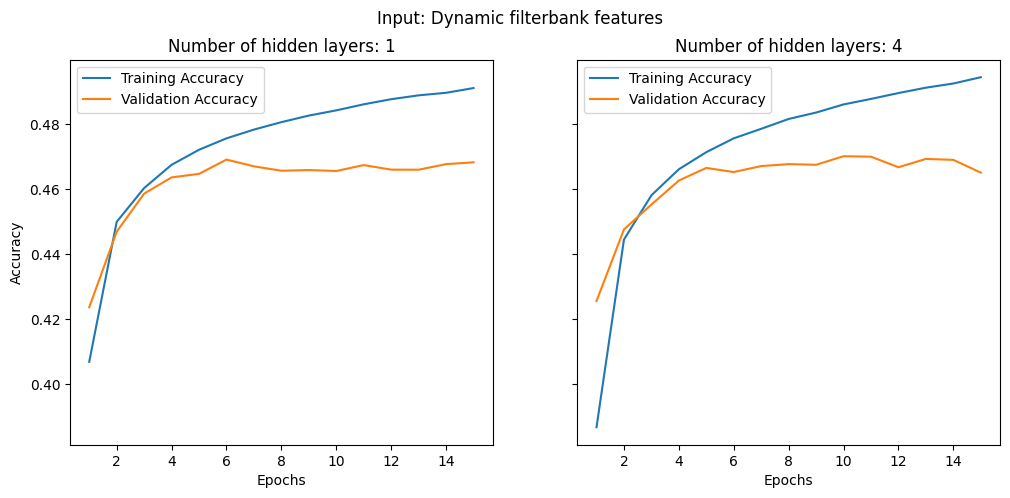

In [37]:
input_size = 280
model_1 = PhonemeDNN(input_size, num_classes, num_hidden_layers=1)
model_4 = PhonemeDNN(input_size, num_classes, num_hidden_layers=4)

train_accuracies_1, val_accuracies_1 = train_model(model_1, dmspec_train_x, train_y, dmspec_val_x, val_y, dmspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
train_accuracies_4, val_accuracies_4 = train_model(model_4, dmspec_train_x, train_y, dmspec_val_x, val_y, dmspec_test_x, test_y, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Two subplots sharing y-axis

# Plot for model with 1 hidden layer
axs[0].plot(range(1, epochs+1), train_accuracies_1, label='Training Accuracy')
axs[0].plot(range(1, epochs+1), val_accuracies_1, label='Validation Accuracy')
axs[0].set_title('Number of hidden layers: 1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

# Plot for model with 4 hidden layers
axs[1].plot(range(1, epochs+1), train_accuracies_4, label='Training Accuracy')
axs[1].plot(range(1, epochs+1), val_accuracies_4, label='Validation Accuracy')
axs[1].set_title('Number of hidden layers: 4')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('')

axs[0].legend()
axs[1].legend()

plt.suptitle('Input: Dynamic filterbank features')
plt.show()

# Possible questions

### What is the influence of feature kind and size of input context window?
The model performance. 

The context window size determines how much of the temporal information surrounding each frame is considered by the network. A larger window provides more contextual information, potentially improving recognition accuracy but also increasing the complexity of the model. Dynamic features, which include several frames of context, typically lead to better performance compared to static features.

### What is the purpose of normalising (standardising) the input feature vectors depending on the activation functions in the network?
Normalising the feature vectors ensures that each feature contributes equally to the learning process, preventing features with larger numerical ranges from dominating the training dynamics. 

This is crucial when using activation functions like sigmoid or tanh in the network, as these functions are sensitive to input scale and can suffer from saturation issues: inputs with large absolute values cause the function outputs to be near the function's asymptotes, resulting in gradients close to zero.

### What is the influence of the number of units per layer and the number of layers?
Increasing the number of units per layer typically allows the network to learn more complex patterns and representations, improving its capability to differentiate between more subtle features of the input. 

Similarly, more layers can enable deeper (hence, potentially more abstract) feature learning. 

However, larger and deeper networks are more prone to overfitting and require more data and computational resources to train effectively.

### What is the influence of the activation function (when you try other activation functions than ReLU, you do not need to reach convergence in case you do not have enough time)
The choice of activation function affects the training dynamics and the performance of the network. 

ReLU (Rectified Linear Unit) is commonly used because it helps in alleviating the vanishing gradient problem encountered with sigmoid or tanh functions. 

Trying other activation functions like Leaky ReLU, ELU, or sigmoid might affect convergence speed and the final model performance, especially if the network architecture or data characteristics make it susceptible to issues like dying ReLU problem or gradient vanishing/explosion.

### What is the influence of the learning rate/learning rate strategy?
Too high a rate can cause the training to diverge, while too low a rate might result in a painfully slow convergence or getting stuck in local minima. 

Adaptive learning rate strategies like Adam adjust the learning rate during training, which can lead to faster convergence and can alleviate some of the tuning requirements.

### How stable are the posteriograms from the network in time?
Posteriors produced by the network should ideally be stable for consistent phonetic units across similar contexts. 

However, in practice, stability can vary depending on factors like network architecture, training sufficiency, and the inherent variability of speech. Observing fluctuations in posteriograms can indicate issues with model generalization or insufficient training.

### How do the errors distribute depending on phonetic class?
Errors in phoneme recognition often vary by phonetic class. 

Some phonemes might be consistently harder to recognize due to their acoustic similarity to other phonemes, less distinctiveness in their spectral features, or their shorter duration. 

Confusion matrices by phonetic class can help identify which phonemes are most frequently misclassified and which phonemes they are confused with, guiding further model adjustments or targeted data augmentation.
